In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [2]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 1             # 추출할 주파수 개수
design_region_resolution = 50

In [3]:
tag_bot         = 0.5
tag_side        = 4
tsio2           = 4
tdesignregion   = 1
monitor_position =  1 / fcen * 2
monitor_blank   = 1 / fcen * 0.1

tpml = 0.4

width_ag = 0.2
width_sio2 = 2

width_bot_ag = width_ag+width_sio2+width_ag

design_region_width = round(width_bot_ag, 3)
design_region_height = 1

Sx = tpml+width_bot_ag+tpml
Sy = round(tag_bot+tag_side+tdesignregion+monitor_position+monitor_blank+tpml)

SiO2 = mp.Medium(index = 1.45)
TiO2 = mp.Medium(index = 2.6)

Nx = int(design_region_resolution * design_region_width) + 1
# Ny = int(design_region_resolution * design_region_height) + 1
Ny = 1

y_bottom = -Sy/2
center_y_ag = y_bottom + tag_bot / 2
center_y_sio2 = y_bottom + tag_bot + tsio2 / 2
center_y_design = y_bottom + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tag_bot + 1/fcen 
center_Ag_x_position = design_region_width/2-width_ag/2 #+ tpml/2

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), TiO2, SiO2,  grid_type="U_MEAN")

# design_region = mpa.DesignRegion(
#     design_variables,
#     volume=mp.Volume(
#         center=mp.Vector3(0, center_y_design, 0),
#         size=mp.Vector3(design_region_width, design_region_height, 0),
#     ),
# )


boundary_layers = [mp.Absorber(tpml,direction=mp.X),
                   mp.PML(tpml,direction=mp.Y,side=mp.High)]

In [4]:
# 셀 크기 설정
cell_size = mp.Vector3(Sx, Sy)

# 기본 지오메트리 정의
geometry = [
    # Bottom Ag layer
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    # SiO2 layer
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    # Side metal
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]


In [51]:
# 몇개의 layer로 최적화를 할건지 설정하고 싶다면 layer_num 갯수 조절
layer_num = 3

ML = (layer_num > 1)

region_height_each = design_region_height / layer_num
full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

if ML:
    design_variables = []
    design_region = []
    for dv in range(layer_num):
        mg = mp.MaterialGrid(
            mp.Vector3(Nx, Ny),
            TiO2,       
            SiO2,       
            grid_type="U_MEAN",
            do_averaging=False
        )
        design_variables.append(mg)
        offset = ((layer_num - 1) / 2 - dv) * region_height_each
        center_y = full_center_y + offset

        dr = mpa.DesignRegion(
            mg,
            volume=mp.Volume(
                center=mp.Vector3(0, center_y, 0),
                size=mp.Vector3(design_region_width, region_height_each, 0),
            ),
        )
        design_region.append(dr)

        geometry.append(
            mp.Block(
                material=design_variables[dv],
                size=design_region[dv].size,
                center=design_region[dv].center
            )
        )
else:
    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        TiO2,
        SiO2,
        grid_type="U_MEAN",
        do_averaging=False
    )
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(0, full_center_y, 0),
            size=mp.Vector3(design_region_width, region_height_each, 0),
        )
    )
    geometry.append(
        mp.Block(
            material=design_variables,
            size=design_region.size,
            center=design_region.center
        )
    )


In [52]:
src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = mp.Source(
            src,
            component=mp.Ez,
            center=mp.Vector3(
                0,
                center_y_source_position,  # Alq3 층의 중간 높이
                0
            )
        )

sim = mp.Simulation(
    resolution=resolution,
    sources=[sources],
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry,
    default_material=mp.Medium(index = 1),
    extra_materials=[Ag]
)

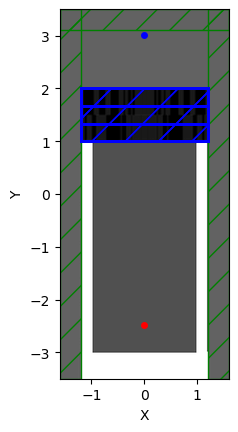

In [54]:
monitor_position_J, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(0,0)
FourierFields = mpa.FourierFields(sim,mp.Volume(center=monitor_position_J,size=monitor_size),mp.Ez,yee_grid=True)
ob_list = [FourierFields]

def J(fields):
    return npa.mean(npa.abs(fields) ** 2) # The index 1 corresponds to the point at the center of our monitor.

opt = mpa.OptimizationProblem(
            simulation=sim,
            objective_functions=[J],
            objective_arguments=ob_list,
            design_regions=design_region,        # 한 개의 DesignRegion
            frequencies=[fcen],
            maximum_run_time=100,
        )

opt.plot2D(True)

In [55]:
class AdamOptimizer:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, warmup_iters=10):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mt = None
        self.vt = None
        self.iter = 0
        self.warmup_iters = warmup_iters
    
    def update(self, v, gradient):
        if self.mt is None:
            self.mt = np.zeros_like(v)
        if self.vt is None:
            self.vt = np.zeros_like(v)
            
        #Adam에서는 기울기 값과 기울기의 제곱값의 지수이동평균을 활용하여 step 변회량을 조절
        self.iter += 1
        self.mt = self.beta1 * self.mt + (1 - self.beta1) * gradient           #m_(t)=beta_(1)*m_(t-1)+(1-beta_(1))*gradient
        self.vt = self.beta2 * self.vt + (1 - self.beta2) * (gradient ** 2)       #v_(t)=beta_(2)*v_(t-1)+(1-beta_(2))*(gradeint^2)
        
        # 초기 몇번의 update에서 0으로 편향되어 있어서 출발 지점에서 멀리 떨어진 곳으로 이동하는, 초기 경로의 편향 문제를 해결 하기 위해 unbiased하게 만들어줌
        m_hat = self.mt / (1 - self.beta1 ** self.iter)   #m_hat=m/(1-beta1**t)
        v_hat = self.vt / (1 - self.beta2 ** self.iter)
        
        # Warm-up 단계
        if self.iter <= self.warmup_iters:
            warmup_factor = self.iter / self.warmup_iters
            lr = self.lr * warmup_factor
        else:
            lr = self.lr   #lr_t <- alpha*sqrt
            
        #update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        update_factor= m_hat / (np.sqrt(v_hat) + self.epsilon) #theta_t <- theta_(t-1)-alpha_(t)*m_(t)/(sqrt(v_(t))+epsilon) alpha_(t)=learning rate
        update = lr * update_factor
        updated_v = v + update
        updated_v = np.clip(updated_v, 0.0, 1.0)
        
        adam_lr=np.mean(np.abs(update))
        adam_uf=np.mean(np.abs(update_factor))
        
        # adam_beta1=self.beta1
        # # adam_beta2=self.beta2
        adam_m=self.mt
        adam_v=self.vt
        adam_t=self.iter
        
        return updated_v, adam_lr, adam_uf, adam_m, adam_v, adam_t

In [56]:
eta_i = 0.5
def multi_mapping(x, eta_i, beta):
    size_each = Nx * Ny
    v3 = x.reshape(layer_num, size_each)

    rho_list = []
    for i in range(layer_num):
        layer_field = v3[i].reshape(Nx, Ny)
        layer_field = (np.flipud(layer_field) + layer_field) / 2
        flat = layer_field.flatten()
        proj = mpa.tanh_projection(flat, beta, eta_i)
        rho_list.append(proj)          

    stacked = np.concatenate(rho_list, axis=0)  
    return stacked


--- Iter 1 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.0149988751012406
Current FOM: 0.0001326988033517393
Binary degree : 0.0 


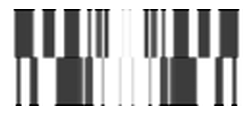


--- Iter 2 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.0301477048726144
Current FOM: 0.00015549440773112583
Binary degree : 0.003998577597652819 


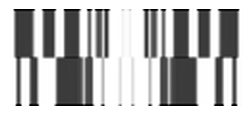


--- Iter 3 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.0454479878283762
Current FOM: 0.0001977244732463494
Binary degree : 0.011821699071729828 


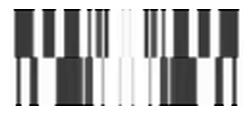


--- Iter 4 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.060901237436652
Current FOM: 0.0002627821500508833
Binary degree : 0.02345996803755067 


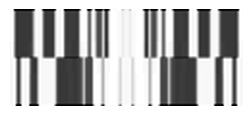


--- Iter 5 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 2.07650898226803
Current FOM: 0.0003514666003969594
Binary degree : 0.03838770439863622 


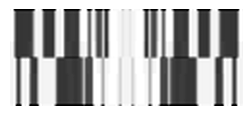


--- Iter 6 ---
Starting forward run...


KeyboardInterrupt: 

In [58]:
n = Nx*layer_num
x = np.ones(n) * 0.5
cur_beta = 2

# 3) Histories
cur_iter             = [0]
evaluation_history   = []
beta_history         = []
binarization_history = []

g_histories   = [[] for _ in range(layer_num)]
x_histories   = [[] for _ in range(layer_num)]
lr_histories  = [[] for _ in range(layer_num)]
uf_histories  = [[] for _ in range(layer_num)]
t_histories   = [[] for _ in range(layer_num)]

# 4) One AdamOptimizer per layer
optimizers = [AdamOptimizer(lr=0.02, beta1=0.9) for _ in range(layer_num)]

def f_multi(v, eta, beta):
    bin_deg = np.sum(np.abs(v - 0.5)) / (0.5 * v.size)
    binarization_history.append(bin_deg)
    print(f"\n--- Iter {cur_iter[0]+1} ---")

    rho_full = multi_mapping(v, eta, beta)

    size_each = Nx*Ny
    rho_list = [rho_full[i*size_each:(i+1)*size_each]
                for i in range(layer_num)]

    # 4) adjoint 한 번 호출
    f0, grads = opt(rho_list,
                    need_value=True,
                    need_gradient=True,
                    beta=beta)
    
    if not isinstance(grads, (list, tuple)):
        grads = [grads]

    # 5) per-layer gradient
    grad_list = [np.array(grads[i]).flatten() for i in range(layer_num)]

    # 6) per-layer Adam update
    vs = v.reshape(layer_num, size_each)
    v_new_layers = []
    for i in range(layer_num):
        vi_new, lr, uf, m, vt, t = optimizers[i].update(vs[i], grad_list[i])
        lr_histories[i].append(lr)
        uf_histories[i].append(uf)
        t_histories[i].append(t)
        g_histories[i].append(grad_list[i].copy())
        x_histories[i].append(vi_new.copy())
        v_new_layers.append(vi_new)

    # 7) 다시 한 벡터로 합치기
    v_new = np.concatenate(v_new_layers)

    # 8) beta, FoM 기록
    beta_new = beta + np.tanh((beta - 0.5)*0.01)
    evaluation_history.append(float(np.real(f0)))
    beta_history.append(beta_new)
    cur_iter[0] += 1

    print("Current beta: {}".format(beta_new))
    print("Current FOM: {}".format(f0))
    print("Binary degree : {} ".format(bin_deg))

    plt.figure(figsize=(3,2))
    ax = plt.gca()
    opt.plot2D(
        False,
        output_plane=mp.Volume(
            size=mp.Vector3(design_region_width,region_height_each*layer_num,0),
            center=mp.Vector3(0, full_center_y,0)
        ),
        ax=ax,
        show_sources=False,
        show_monitors=False,
        show_boundary_layers=False,
    )
    ax.axis("off")
    plt.show()

    return v_new, beta_new

mp.verbosity(0)
Max_iter = 150
# Main loop (변경 없음)
while cur_iter[0] < Max_iter:
    x, cur_beta = f_multi(x, eta_i, cur_beta)
    if binarization_history[-1] > 0.95:
        print("Threshold reached → final mapping with β=∞")
        x, _ = f_multi(x, eta_i, np.inf)
        break

In [272]:
foms = np.real(evaluation_history_adam)
best_idx = np.argmax(foms)

init_idx = 4  # 0-based index → 5번째
if len(foms) > init_idx:
    init_fom    = foms[init_idx]
    init_beta   = beta_history[init_idx]
    init_design = x_history[init_idx]
    print(f"[Iteration 5] FoM = {init_fom:.4e}, β = {init_beta:.4f}, 디자인 (첫 10개) = {init_design[:10]} …")
else:
    print(f"Iteration 수({len(foms)})가 5보다 작아 5번째 정보가 없습니다.")

# --- 2) FoM 최대일 때 정보 ---
best_fom    = foms[best_idx]
best_beta   = beta_history[best_idx]
best_design = x_history[best_idx]
print(f"[Best Iteration {best_idx+1}] FoM = {best_fom:.4e}, β = {best_beta:.4f}, 디자인 (첫 10개) = {best_design[:10]} …")

# --- 3) 마지막 iteration 정보 ---
last_idx    = len(foms) - 1
last_fom    = foms[last_idx]
last_beta   = beta_history[last_idx]
last_design = x_history[last_idx]
print(f"[Last Iteration {last_idx+1}] FoM = {last_fom:.4e}, β = {last_beta:.4f}, 디자인 (첫 10개) = {last_design[:10]} …")


NameError: name 'evaluation_history_adam' is not defined

In [26]:
# 1) 배열로 변환
eval_hist = np.array(evaluation_history)

# 2) 최대값과 그 인덱스 찾기 (0-based)
max_val   = eval_hist.max()
max_idx0  = eval_hist.argmax()

# 3) 사람이 셀 때 보통 1부터 시작하니 +1
iteration = max_idx0 + 1

print(f"최대 FoM = {max_val:.6f} 는 iteration {iteration} 에서 나왔습니다.")

최대 FoM = 0.013777 는 iteration 54 에서 나왔습니다.


7.168011764489319

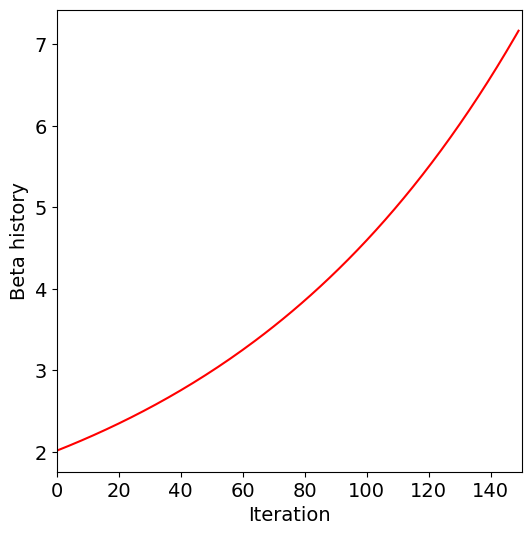

In [27]:
plt.figure(figsize = (6,6))
plt.plot(beta_history, 'r-')
plt.xlabel('Iteration',fontsize = 14)
plt.ylabel('Beta history',fontsize = 14)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.xlim(0, np.array(cur_iter))
# plt.ylim(5,max(beta_history))

max(beta_history)

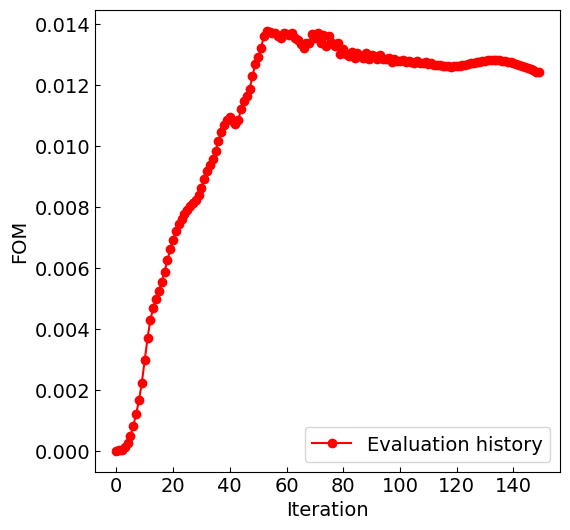

In [28]:
plt.figure(figsize = (6,6))

plt.plot(evaluation_history, 'or-',   label='Evaluation history',)

plt.xlabel('Iteration',fontsize = 14)
plt.ylabel('FOM',fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

# plt.title('Optimization', fontsize = 16)
plt.tick_params(direction = 'in')

plt.legend( fontsize = 14,)

plt.show()

0.7792002650153128

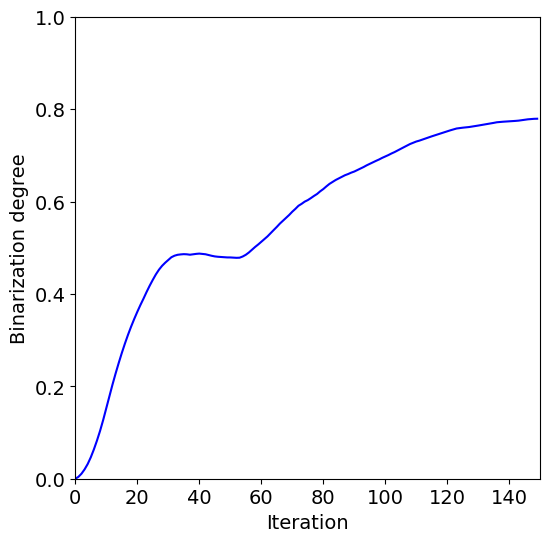

In [50]:
plt.figure(figsize = (6,6))
plt.plot(binarization_history, 'b-')
plt.xlabel('Iteration',fontsize = 14)
plt.ylabel('Binarization degree',fontsize = 14)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.xlim(0, np.array(cur_iter))
plt.ylim(0,1)

max(binarization_history)

In [ ]:
# multi2 = design_variables[0].weights
# multi1 = design_variables[1].weights

opt.update_design([multi2, multi1])

(-1.2, 1.2, 1.0, 2.0)

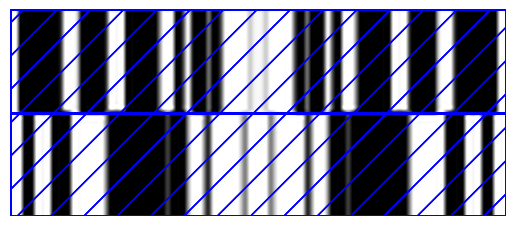

In [31]:
opt.plot2D(
    True,
    output_plane = mp.Volume(size = mp.Vector3(2.4, 1, 0), center = mp.Vector3(0, full_center_y,0)),
    
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
plt.axis(False)

<Axes: xlabel='X', ylabel='Y'>

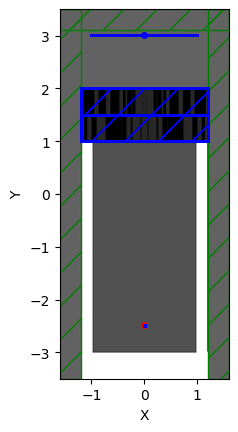

In [32]:
offset = 0.01
flux_size = 0.02
mn_size = 2

monitor_position_y, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(mn_size,0)

#### input source의 flux ####
input_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=sources.center - mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X
                    ),
        mp.FluxRegion(center=sources.center - mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y
                    )
    )

#### output flux -> add flux로 계산한 poynting vector ####
out_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(
                center=monitor_position_y,
                size=monitor_size,
                # direction=mp.Y
                # weight=-1
        )
    )

#### output flux -> 성분별 field를 뽑고, poynting vector를 계산할 예정 ####
dft_fields = opt.sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz], fcen, 0, 1, 
                                    center = monitor_position_y,
                                    size = monitor_size, 
                                    yee_grid=True)

opt.sim.plot2D()


/home/min/miniconda3/envs/mp/lib/python3.9/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


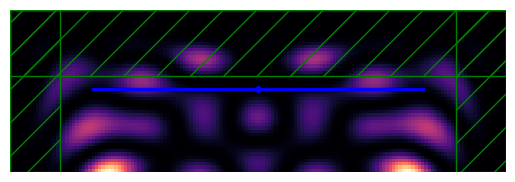

In [33]:
sim.run(until_after_sources=mp.stop_when_fields_decayed(10/df, mp.Ez, sources.center, 1e-3))

opt.sim.plot2D(
    fields=mp.Ez,
    output_plane=mp.Volume(
    center = monitor_position_y,
    size = mp.Vector3(3, 1)),
    field_parameters={
        'post_process': lambda x: np.abs(np.real(x))**2,  # 복소수 필드 x → intensity |x|^2
        'cmap': 'magma',                         # 원하시는 colormap
        'alpha': 1,                            # 투명도
        'interpolation': 'none'
    },
    eps_parameters={'cmap':'magma','alpha':0.5}
)
plt.axis(False)
plt.show()

<Axes: xlabel='X', ylabel='Y'>

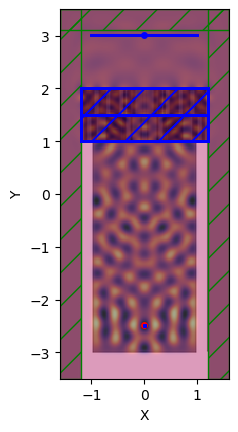

In [34]:
opt.sim.plot2D(fields = mp.Ez,
           field_parameters={
        'cmap': 'magma',    # magma 컬러맵 지정
        'alpha': 0.5,       # 필드 투명도 (0.0~1.0)
        'interpolation': 'none'
    }
)

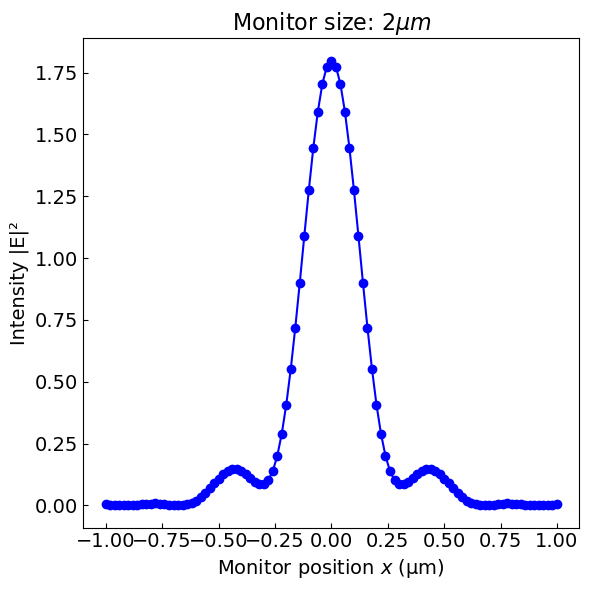

In [42]:
external_field_array = np.abs(sim.get_dft_array(dft_fields, mp.Ez, 0))

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot(x, I, 'bo-')


plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
# plt.ylabel('phase',       fontsize=14)
plt.title(r'Monitor size: $2\mu m$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.show()

In [ ]:
eqe = mp.get_fluxes(out_flux)[0]/mp.get_fluxes(input_flux)[0]*100

print("Input flux :", mp.get_fluxes(input_flux)[0])
print("Output flux :", mp.get_fluxes(out_flux)[0])
print("EQE(%) :", eqe,"%")

Input flux : 0.533379165473088
Output flux : 0.7148995657662376
EQE(%) : 134.03215049319513 %


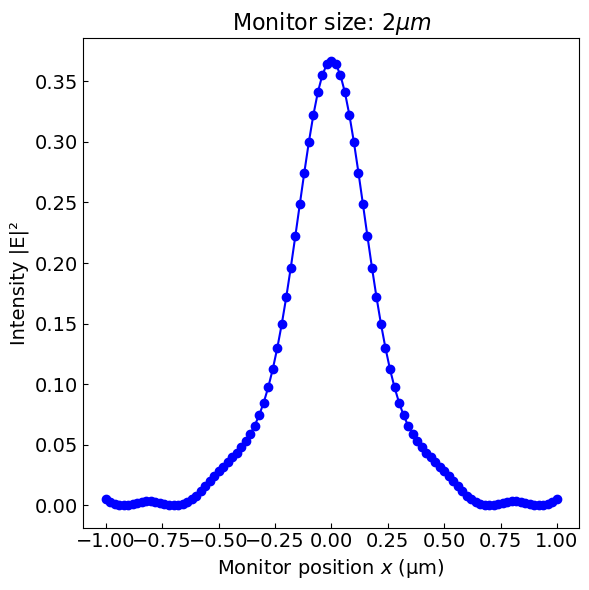

In [47]:
external_field_array = np.real(sim.get_dft_array(dft_fields, mp.Ez, 0))

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot(x, I, 'bo-')


plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
# plt.ylabel('phase',       fontsize=14)
plt.title(r'Monitor size: $2\mu m$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.show()

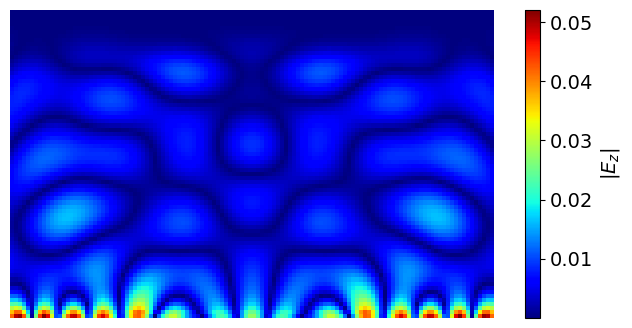

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import meep as mp

nx = int(design_region_resolution * design_region_width) + 1
x_res = np.linspace(-design_region_width/2,
                     design_region_width/2,
                     nx)

y_start = center_y_design + design_region_height/2
y_end   = center_y_monitor_position + 1/fcen
ny = int(design_region_resolution * (y_end - y_start)) + 1
y_res = np.linspace(y_start, y_end, ny)

vol = mp.Volume(
    center=mp.Vector3(0, (y_start + y_end)/2, 0),
    size=  mp.Vector3(design_region_width,
                      y_end - y_start,
                      0)
)
Ez_slice = opt.sim.get_array(mp.Ez, vol).T   # shape == (ny, nx)

plt.figure(figsize=(8,4))
plt.imshow(
    np.abs(Ez_slice),      # (ny, nx)
    origin='lower',
    extent=[x_res.min(), x_res.max(), y_res.min(), y_res.max()],
    aspect='equal',
    cmap='jet'
)

cbar = plt.colorbar()
cbar.set_label(r'$|E_z|$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
# plt.ylabel('Height $y$ (µm)',           fontsize=14)
# plt.title(r'Monitor size: $2\ \mu m$',   fontsize=16)

# 틱 폰트 크기 및 방향 맞추기
plt.tick_params(direction='in', labelsize=14)
# plt.tight_layout()
plt.axis('off')
plt.show()

In [48]:
import numpy as np

I = np.real(external_field_array)**2
N = len(I)
W = mn_size
x = np.linspace(-W/2, W/2, N)
z = abs(center_y_monitor_position - center_y_source_position)

center_idx = np.argmax(I)
# 간단히 for문으로
for i in range(center_idx+1, N-1):
    if I[i] < I[i-1] and I[i] < I[i+1]:
        x_limit = abs(x[i])
        break
else:
    raise RuntimeError("1차 링 경계를 찾을 수 없음")

x_min, x_max = -x_limit, x_limit

mask = (x >= x_min) & (x <= x_max)

x_slice = x[mask]
I_slice = I[mask]

dx = x[1] - x[0]
flux_slice = np.sum(I_slice) * dx   

input = np.array(mp.get_fluxes(input_flux))[0]
output = np.array(mp.get_fluxes(out_flux))[0]

print("Input flux :", input)
print("Output flux :", output)
print(f"±{x_limit:.3f} µm 구간 integrated intensity: {flux_slice}")

optical_eqe = flux_slice/input * 100
print("1차 ring까지의 Optical EQE :", optical_eqe,"%")

Input flux : 0.37430796729724797
Output flux : 0.5281113271681568
±0.700 µm 구간 integrated intensity: 0.16478205284526654
1차 ring까지의 Optical EQE : 44.023121932215965 %


In [37]:
eqe = mp.get_fluxes(out_flux)[0]/mp.get_fluxes(input_flux)[0]*100
    
print("Input flux :", mp.get_fluxes(input_flux)[0])
print("Output flux :", mp.get_fluxes(out_flux)[0])
print("EQE(%) :", eqe,"%")

Input flux : 0.37430796729724797
Output flux : 0.5281113271681568
EQE(%) : 141.09005773547145 %


In [49]:
44.023121932215965/14.909229505096654

2.9527429245868713